In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix#, plot_confusion_matrix  
import seaborn as sns
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
raw_df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
#raw_df.head()

In [3]:
### Giving numerical values to the Gender column
raw_df['gender'].unique()
raw_df['IsFemale'] = raw_df['gender'].map({'Female': 1, 'Male': 0})
raw_df.drop(columns=['gender'], inplace=True)
raw_df.rename(columns={'IsFemale': 'gender'}, inplace=True)
### Giving numerical values to the columns: 'Partner', 'Dependents', 'PhoneService' -> using mapping
raw_df['Partner'].unique()
raw_df['Dependents'].unique()
raw_df['PhoneService'].unique()
raw_df['PaperlessBilling'].unique() #yn
raw_df['Churn'].unique() #yn
yn_mapping = {
    'Yes': 1,
    'No': 0
}
raw_df['Partner'] = raw_df['Partner'].map(yn_mapping)
raw_df['Dependents'] = raw_df['Dependents'].map(yn_mapping)
raw_df['PhoneService'] = raw_df['PhoneService'].map(yn_mapping)
raw_df['PaperlessBilling'] = raw_df['PaperlessBilling'].map(yn_mapping)
raw_df['Churn'] = raw_df['Churn'].map(yn_mapping)
### Giving numerical values to the column: 'MultipleLines'-> using mapping
raw_df['MultipleLines'].unique()
nyns_mapping = {
    'Yes': 1,
    'No': 0,
    'No phone service': -1
}
raw_df['MultipleLines'] = raw_df['MultipleLines'].map(nyns_mapping)
raw_df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender
0,7590-VHVEG,0,1,0,1,0,-1,DSL,No,Yes,...,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0,1
1,5575-GNVDE,0,0,0,34,1,0,DSL,Yes,No,...,No,No,No,One year,0,Mailed check,56.95,1889.5,0,0
2,3668-QPYBK,0,0,0,2,1,0,DSL,Yes,Yes,...,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1,0
3,7795-CFOCW,0,0,0,45,0,-1,DSL,Yes,No,...,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,0
4,9237-HQITU,0,0,0,2,1,0,Fiber optic,No,No,...,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1,1


In [4]:
### One-hot-encoding the column 'InternetService'
raw_df['InternetService'].unique()
raw_df = pd.get_dummies(raw_df, columns=['InternetService'])
raw_df.drop(columns=['InternetService_No'], inplace=True)
raw_df['InternetService_DSL'] = raw_df['InternetService_DSL'].astype(int)
raw_df['InternetService_Fiber optic'] = raw_df['InternetService_Fiber optic'].astype(int)
raw_df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,InternetService_DSL,InternetService_Fiber optic
0,7590-VHVEG,0,1,0,1,0,-1,No,Yes,No,...,No,Month-to-month,1,Electronic check,29.85,29.85,0,1,1,0
1,5575-GNVDE,0,0,0,34,1,0,Yes,No,Yes,...,No,One year,0,Mailed check,56.95,1889.5,0,0,1,0
2,3668-QPYBK,0,0,0,2,1,0,Yes,Yes,No,...,No,Month-to-month,1,Mailed check,53.85,108.15,1,0,1,0
3,7795-CFOCW,0,0,0,45,0,-1,Yes,No,Yes,...,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,0,1,0
4,9237-HQITU,0,0,0,2,1,0,No,No,No,...,No,Month-to-month,1,Electronic check,70.70,151.65,1,1,0,1


In [5]:
#raw_df['OnlineSecurity'].unique()
#raw_df['OnlineBackup'].unique() #same mapping as previous
#raw_df['DeviceProtection'].unique() # same
#raw_df.shape # (7043, 22)
#raw_df[raw_df['OnlineSecurity'] == raw_df['OnlineBackup']].count() ### 4847
#raw_df[(raw_df['OnlineSecurity'] == raw_df['OnlineBackup']) & (raw_df['OnlineBackup']== raw_df['DeviceProtection'])].count() ### 3728 bruuuuuh
#raw_df['TechSupport'].unique() #same
#raw_df['StreamingTV'].unique() #same
#raw_df['StreamingMovies'].unique() #same

### basically mapping everything that had these responses 
### !!!! note to self: check collinearities !!!
nyni_mapping = {
    'Yes': 1,
    'No': 0,
    'No internet service': -1
}
raw_df['OnlineSecurity'] = raw_df['OnlineSecurity'].map(nyni_mapping)
raw_df['OnlineBackup'] = raw_df['OnlineBackup'].map(nyni_mapping)
raw_df['DeviceProtection'] = raw_df['DeviceProtection'].map(nyni_mapping)
raw_df['TechSupport'] = raw_df['TechSupport'].map(nyni_mapping)
raw_df['StreamingTV'] = raw_df['StreamingTV'].map(nyni_mapping)
raw_df['StreamingMovies'] = raw_df['StreamingMovies'].map(nyni_mapping)
raw_df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,InternetService_DSL,InternetService_Fiber optic
0,7590-VHVEG,0,1,0,1,0,-1,0,1,0,...,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,1,0
1,5575-GNVDE,0,0,0,34,1,0,1,0,1,...,0,One year,0,Mailed check,56.95,1889.5,0,0,1,0
2,3668-QPYBK,0,0,0,2,1,0,1,1,0,...,0,Month-to-month,1,Mailed check,53.85,108.15,1,0,1,0
3,7795-CFOCW,0,0,0,45,0,-1,1,0,1,...,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,0,1,0
4,9237-HQITU,0,0,0,2,1,0,0,0,0,...,0,Month-to-month,1,Electronic check,70.70,151.65,1,1,0,1


In [6]:
raw_df.dtypes

customerID                      object
SeniorCitizen                    int64
Partner                          int64
Dependents                       int64
tenure                           int64
PhoneService                     int64
MultipleLines                    int64
OnlineSecurity                   int64
OnlineBackup                     int64
DeviceProtection                 int64
TechSupport                      int64
StreamingTV                      int64
StreamingMovies                  int64
Contract                        object
PaperlessBilling                 int64
PaymentMethod                   object
MonthlyCharges                 float64
TotalCharges                    object
Churn                            int64
gender                           int64
InternetService_DSL              int32
InternetService_Fiber optic      int32
dtype: object

In [7]:
### one-hot-encoding contract types
raw_df['Contract'].unique()
raw_df = pd.get_dummies(raw_df, columns=['Contract'])
raw_df.drop(columns=['Contract_Two year'], inplace=True)
raw_df['Contract_Month-to-month'] = raw_df['Contract_Month-to-month'].astype(int)
raw_df['Contract_One year'] = raw_df['Contract_One year'].astype(int)
raw_df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year
0,7590-VHVEG,0,1,0,1,0,-1,0,1,0,...,1,Electronic check,29.85,29.85,0,1,1,0,1,0
1,5575-GNVDE,0,0,0,34,1,0,1,0,1,...,0,Mailed check,56.95,1889.5,0,0,1,0,0,1
2,3668-QPYBK,0,0,0,2,1,0,1,1,0,...,1,Mailed check,53.85,108.15,1,0,1,0,1,0
3,7795-CFOCW,0,0,0,45,0,-1,1,0,1,...,0,Bank transfer (automatic),42.30,1840.75,0,0,1,0,0,1
4,9237-HQITU,0,0,0,2,1,0,0,0,0,...,1,Electronic check,70.70,151.65,1,1,0,1,1,0


In [8]:
raw_df['PaymentMethod'].unique() #['Electronic check', 'Mailed check', 'Bank transfer (automatic)','Credit card (automatic)']
raw_df = pd.get_dummies(raw_df, columns=['PaymentMethod'])
raw_df.drop(columns=['PaymentMethod_Electronic check'], inplace=True)
raw_df['PaymentMethod_Mailed check'] = raw_df['PaymentMethod_Mailed check'].astype(int)
raw_df['PaymentMethod_Bank transfer (automatic)'] = raw_df['PaymentMethod_Bank transfer (automatic)'].astype(int)
raw_df['PaymentMethod_Credit card (automatic)'] = raw_df['PaymentMethod_Credit card (automatic)'].astype(int)
raw_df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,TotalCharges,Churn,gender,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check
0,7590-VHVEG,0,1,0,1,0,-1,0,1,0,...,29.85,0,1,1,0,1,0,0,0,0
1,5575-GNVDE,0,0,0,34,1,0,1,0,1,...,1889.5,0,0,1,0,0,1,0,0,1
2,3668-QPYBK,0,0,0,2,1,0,1,1,0,...,108.15,1,0,1,0,1,0,0,0,1
3,7795-CFOCW,0,0,0,45,0,-1,1,0,1,...,1840.75,0,0,1,0,0,1,1,0,0
4,9237-HQITU,0,0,0,2,1,0,0,0,0,...,151.65,1,1,0,1,1,0,0,0,0


In [9]:
raw_df[raw_df['TotalCharges'] == ' '].count()
raw_df = raw_df[raw_df['TotalCharges'] != ' '] ### removing na-s
raw_df['TotalCharges'] = raw_df['TotalCharges'].astype(float)
raw_df.dtypes

customerID                                  object
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
gender                                       int64
InternetService_DSL                          int32
InternetService_Fiber optic    

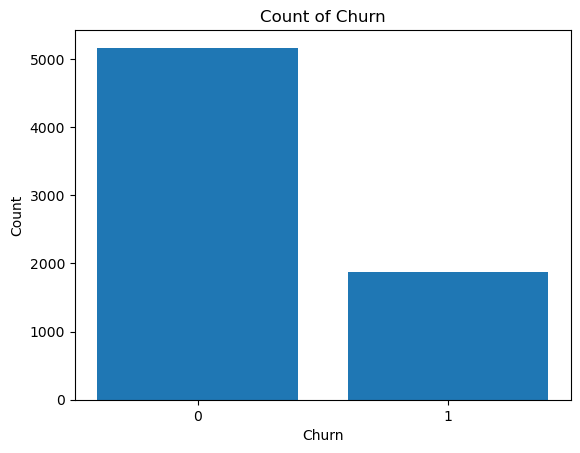

In [10]:
churn_counts = raw_df['Churn'].value_counts()
plt.bar(churn_counts.index.astype(str), churn_counts.values)
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count of Churn')
plt.show()

In [11]:
raw_df.drop(columns=['customerID'], inplace=True)

In [12]:
X = raw_df
y = raw_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

In [18]:
X_train.drop(columns=['Churn'], inplace=True)
X_test.drop(columns=['Churn'], inplace=True)

In [21]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
import numpy as np

#classifier = RandomForestClassifier()
classifier = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=1)

selector = RFECV(classifier, cv=5, scoring='roc_auc', n_jobs=-1)
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[selector.support_]

# Step 2: Train a classifier using the selected features
classifier.fit(X_train[selected_features], y_train)

# Step 3: Use cross-validation to predict probabilities
cv = StratifiedKFold(n_splits=5)
probabilities = cross_val_predict(classifier, X_train[selected_features], y_train, cv=cv, method='predict_proba')[:, 1]

# Step 4-7: Iterate through different thresholds and select the one with the best recall
#best_recall = 0
#best_threshold = 0
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
for threshold in thresholds:
    y_pred = (probabilities >= threshold).astype(int)
    recall = recall_score(y_train, y_pred)   ###PREDICT PROBAS!!!!
    f1 = f1_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    print(f"Threshold: {threshold}, Recall: {recall},F1: {f1}, Precision: {precision}")

Threshold: 0.3, Recall: 0.7739130434782608,F1: 0.6305177111716621, Precision: 0.5319540229885057
Threshold: 0.35, Recall: 0.7311036789297659,F1: 0.6338069005508844, Precision: 0.5593654042988742
Threshold: 0.4, Recall: 0.6555183946488294,F1: 0.6220247540463345, Precision: 0.5917874396135265
Threshold: 0.45, Recall: 0.5491638795986622,F1: 0.5887414844030119, Precision: 0.634466769706337
Threshold: 0.5, Recall: 0.4729096989966555,F1: 0.5540752351097178, Precision: 0.6688741721854304
Threshold: 0.55, Recall: 0.4013377926421405,F1: 0.507399577167019, Precision: 0.6896551724137931
Threshold: 0.6, Recall: 0.3277591973244147,F1: 0.45433472415391757, Precision: 0.7401812688821753
Threshold: 0.65, Recall: 0.22809364548494984,F1: 0.35281945162959133, Precision: 0.7785388127853882


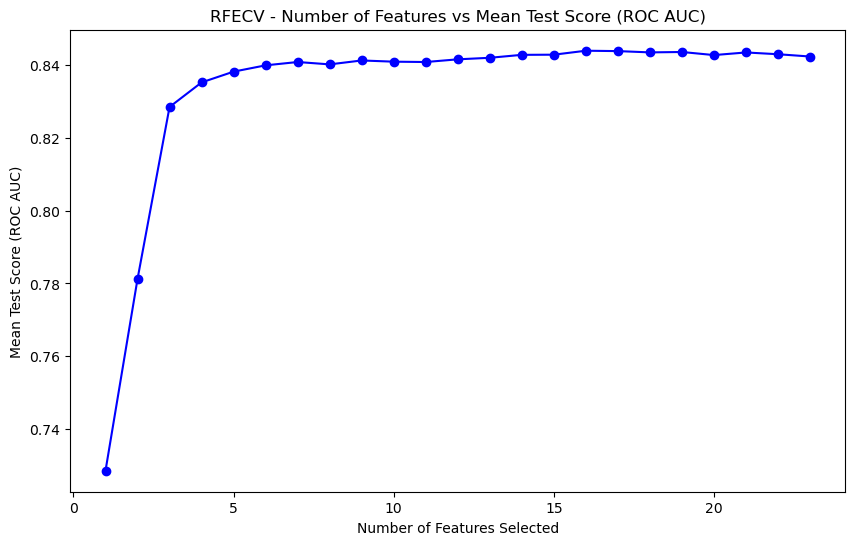

In [22]:
mean_test_scores = selector.cv_results_["mean_test_score"]
num_features = range(1, len(mean_test_scores) + 1)
plt.figure(figsize=(10, 6))
plt.plot(num_features, mean_test_scores, marker='o', linestyle='-', color='b')
plt.title('RFECV - Number of Features vs Mean Test Score (ROC AUC)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Test Score (ROC AUC)')
plt.show()

In [38]:
raw_df.drop(columns=['Churn'], inplace=True)

In [40]:
final_df = raw_df.loc[:, selector.support_]
final_df.head()
final_df.shape #(5625, 16)
y.shape # (7032,)
X.shape
raw_df.shape

(7032, 23)

In [41]:
X = final_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

In [42]:
import joblib
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Create an instance of XGBClassifier
xgb_classifier = XGBClassifier()

# Perform grid search using cross-validation with 5 folds
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Save the best model to a file using joblib
model_file_path = 'xgboost_model.joblib'
joblib.dump(grid_search.best_estimator_, model_file_path)

# Print the best parameters found by grid search
print("Best parameters found by grid search:", grid_search.best_params_)

threshold = 0.4
# Make predictions with the best model
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found by grid search: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


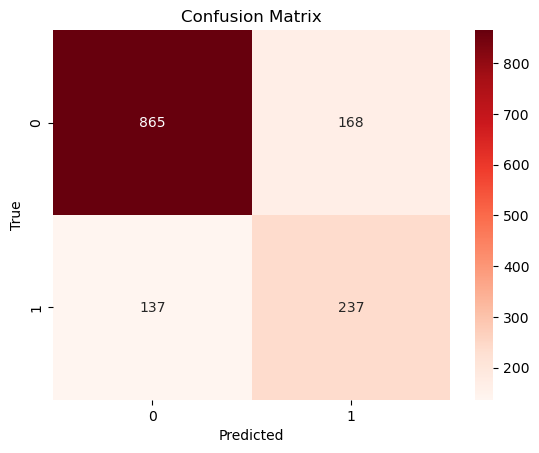

In [43]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]
print("ROC-AUC score:", roc_auc_score(y_test, y_pred_proba))
threshold_analysis = pd.DataFrame(columns=["Threshold", "Accuracy", "Precision", "Recall", "F1"])

for idx, thresh in enumerate(thresholds):
    y_pred = (y_pred_proba>thresh).astype(int)
    new_res = pd.DataFrame(data=
        {"Threshold" : thresh,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),}, index=[idx])
    threshold_analysis = pd.concat([threshold_analysis, new_res], axis=0)

ROC-AUC score: 0.8415238312169011


In [45]:
threshold_analysis[["Threshold", "Precision", "Recall"]].plot(x="Threshold", y=["Precision", "Recall"],  backend="plotly")#ry

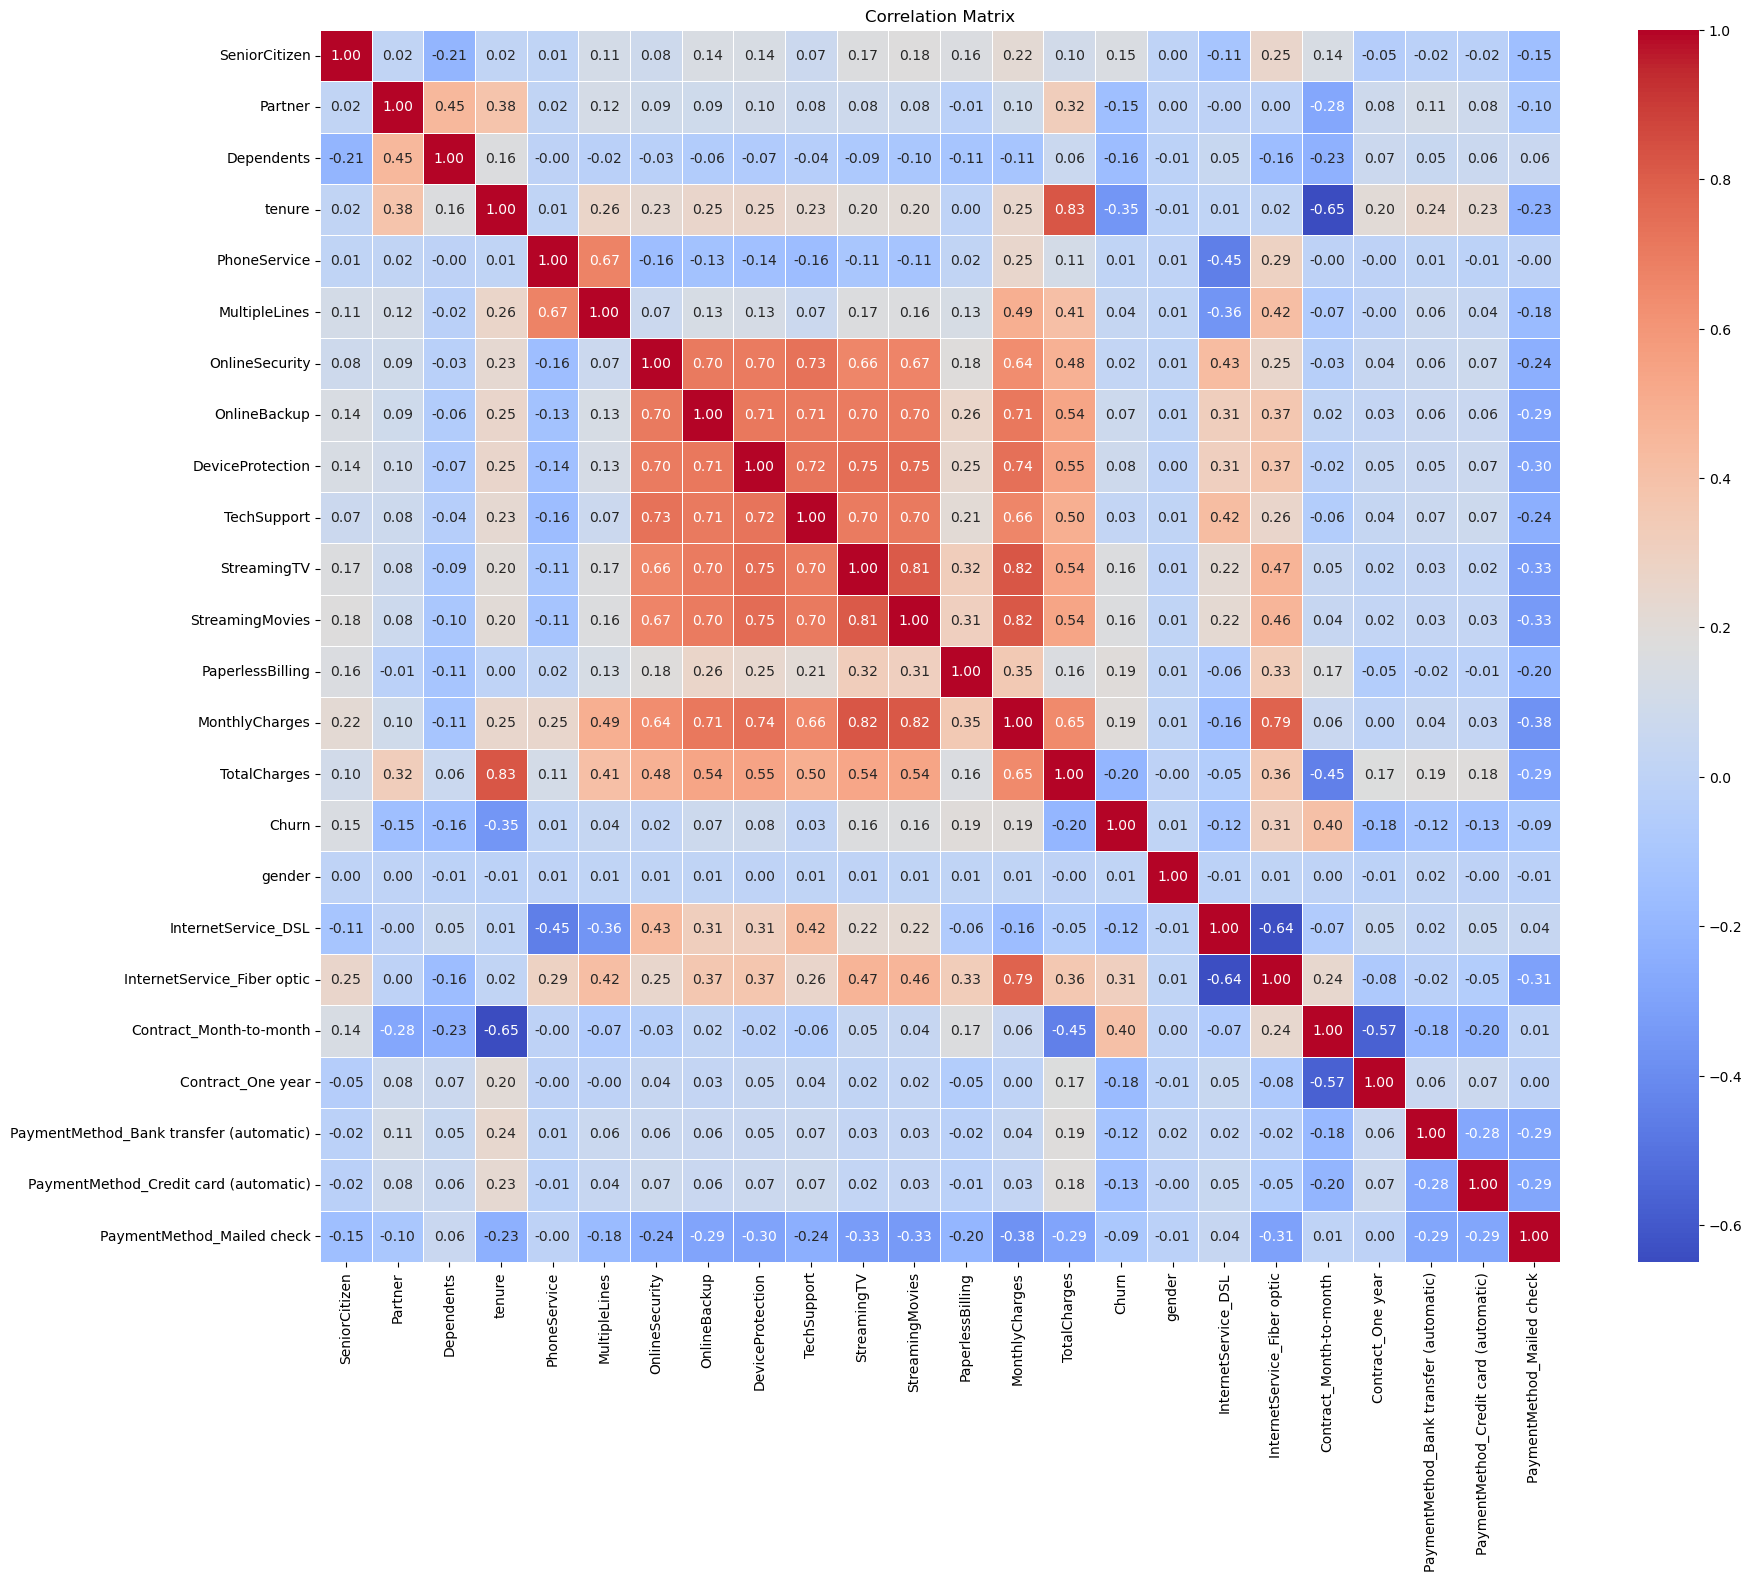

In [24]:
correlation_matrix = raw_df[['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'Contract_Month-to-month', 'Contract_One year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check']].corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()